<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_1_Data_Availability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prerequisites**

Before taking this module, you must have the following

* A Google Earth Engine Account
* A Google Cloud Project tied to your Google Earth Engine account.
* A Google Drive account.
* Google Colaboratory installed on your Google Drive

# **Introduction**

In this module, we will determine the availability of cloud-free optical data for a flood event of your interest. We are searching for a flood event in which there is a

- Sentinel-1 overpass over the area of interest during the time of interest
- Harmonized Landsat and Sentinel-2 (HLS) overpass over the area of interest during the time of interest
- low prevalence of cloud in all optical sensors used to create flood products (HLS, MODIS, VIIRS).

If we find a suitable flood event, we will export the area within the area of interest in which there is an overlap between the HLS and Sentinel-1 overpass geometries.

## **Step 1: Create GEE Directory**

- 1. Open the [Google Earth Engine Code Editor](https://code.earthengine.google.com/)

- 2. Navigate to the Assets Tab in the upper right.

- 3. Create a new folder by clicking the "New Button". Enter in a name or path for the folder. **This will be our parent folder, and will be where we upload all of the flood products**. My parent folder is called "users/mickymags/flood_intercomparison", but you can call yours whatever you like.

- 4. Create a folder in which to hold each of the flood products within the parent folder by clicking the "New" button, and creating a folder within the parent folder called "mcdwd", "vfm", "dswx", and "gfm" respectively. When you are done, your assets folder should look similar to the bottom of the picture below.



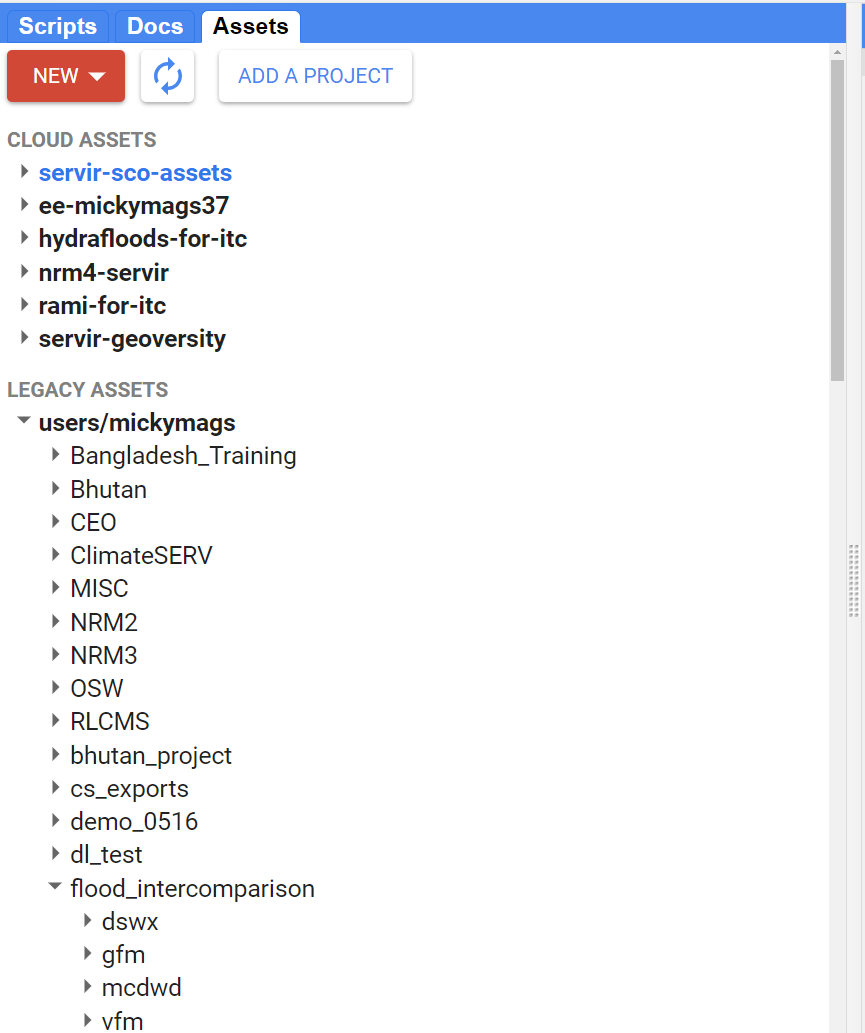





# Step 2: Define Inputs

After modifying the cells below to suit your case study and Earth Engine account, the rest of the cells should run as is.



In [ ]:
# Google Earth Engine Variables
# parent_directory = "users/mickymags/flood_intercomparison/"   # Define the path to the directory you created in step 1. This will either begin with "users/..." or "projects/...""
parent_directory = "projects/servir-sco-assets/assets/flood_intercomparison/pk_case_study/"
aoi_asset_name = 'aoi'                                        # Define what you want the asset name of your area of interest to be
gee_project_name = "servir-sco-assets"

# Google Drive Variables
#Pick the Google Drive Folder where you want to export the area of interest
# This is an optional folder
gd_folder = ''

# Case Study Variables
doi = "2023-06-16"                                            # Enter the Date of Interest in "YYYY-MM-DD"
country = 'Pakistan'                                          # Enter country name as a string
district = 'Punjab'                                           # Enter district name of aoi as a string
s2_cloud_probability_threshold = 5                            # Enter the cloud probability threshold for Sentinel-2

# Step 3: Import packages

We need to import a couple packages for this analysis.

1. The Earth Engine package will allow us to obtain data from Earth Engine and perform some operations on the data.
2. The [geemap](https://geemap.org/) Python package allows for further analysis and visualization using Earth Engine data.
3. The Google Drive package will allow us to export imagery and data from this notebook to your Google Drive.


In [ ]:
from google.colab import drive       # Import Google Drive
import ee                            # Import the Earth Engine package
import geemap                        # Import the Google Earth Engine Python package (geemap)

Now we need to Authenticate Earth Engine, and initilaze it.

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'servir-sco-assets')

# Step 4: Get input data


For this project, we want to compare six flood products/software to each other. Some of these have different input datasets from optical and SAR sensors, which we detail below. In this notebook, we will examine the quality assurance infromation from all of the input datasets to determine if a case study is suitable for optical analysis.


* GFM: The Copernicus Global Flood Monitor. For more information see [this website](https://global-flood.emergency.copernicus.eu/technical-information/glofas-gfm/).
  * Input Dataset: Sentinel-1 uses IW GRDH product, which we can obtain from Google Earth Engine
*  TERRA: The Terra product used as input to the MCDWD product has the following DOI a(http://doi.org/10.5067/MODIS/MOD09.NRT.061) (Slayback et al ___). This product is not available in GEE. Thus, we will use a similar MODIS product in order to estimate the cloud cover in the region of interest
* AQUA: The Aqua product used as input to the MCDWD product is not specified. Email sent 09/05/24
* HLS: The HLS product is split into two datasets, one for Sentinel and one for Landsat. The Sentinel HLS product is not currently available on GEE.



In [ ]:
sentinel1 = ee.ImageCollection("COPERNICUS/S1_GRD") # Sentinel-1 Ground Range Detected
hls_landsat = ee.ImageCollection("NASA/HLS/HLSL30/v002")
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
terra = ee.ImageCollection("MODIS/061/MOD09GA")
aqua = ee.ImageCollection("MODIS/061/MYD09GA")
viirs = ee.ImageCollection("NASA/VIIRS/002/VNP09GA")

Let's filter the Sentinel-1 collection to just those images that are used by the GFM flood Product. GFM ingests observations from the Sentinel-1 satellites that are acquired in the Interferometric Wide-swath (IW imaging mode) (Matgen et al 2022). GFM uses the Ground Range Detected at High Resolution (GRDH) product from Sentinel-1 to create the GFM Water Product (Matgen et al 2021).

In [ ]:
# Sentinel-1 Filtered to interferometric width
s1filt = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW'))\
                  .filter(ee.Filter.eq('resolution', 'H'))          # Filter to High Resolution Scenes

Get a date of interest

In [ ]:
dayafter = ee.Date(doi).advance(1, "day")

Get an area of interest

In [ ]:
gaul = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

In [ ]:
aoi = gaul.filter(ee.Filter.eq('ADM0_NAME', country)).filter(ee.Filter.eq('ADM1_NAME', district))

In [ ]:
aoi

In [ ]:
s1final = s1filt.filterDate(doi, dayafter).filterBounds(aoi)

In [ ]:
s1final

In [ ]:
s1vp = {
    'bands': ['VV'],
    'min': -25,
    'max': 0
}

In [ ]:
s1geom = s1final.geometry()

In [ ]:
s1geom

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.filter",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.filter",
                      "arguments": {
                        "collection": {
                          "functionInvocationValue": {
                            "functionName": "Collection.filter",
                            "arguments": {
                              "collection": {
                                "functionInvocationValue": {
                                  "functionName": "ImageCollection.load",
                                  "arguments": {
                                    "id": {
                                      "constantValue": "COPERNICUS/S1_GRD"
                                    }
                                  }
                                }
                              },
                              "filter": {
                                "functionInvocationValue": {
                                  "functionName": "Filter.equals",
                                  "arguments": {
                                    "leftField": {
                                      "constantValue": "instrumentMode"
                                    },
                                    "rightValue": {
                                      "constantValue": "IW"
                                    }
                                  }
                                }
                              }
                            }
                          }
                        },
                        "filter": {
                          "functionInvocationValue": {
                            "functionName": "Filter.equals",
                            "arguments": {
                              "leftField": {
                                "constantValue": "resolution"
                              },
                              "rightValue": {
                                "constantValue": "H"
                              }
                            }
                          }
                        }
                      }
                    }
                  },
                  "filter": {
                    "functionInvocationValue": {
                      "functionName": "Filter.dateRangeContains",
                      "arguments": {
                        "leftValue": {
                          "functionInvocationValue": {
                            "functionName": "DateRange",
                            "arguments": {
                              "end": {
                                "functionInvocationValue": {
                                  "functionName": "Date.advance",
                                  "arguments": {
                                    "date": {
                                      "functionInvocationValue": {
                                        "functionName": "Date",
                                        "arguments": {
                                          "value": {
                                            "constantValue": "2023-06-16"
                                          }
                                        }
                                      }
                                    },
                                    "delta": {
                                      "constantValue": 1
                                    },
                                    "unit": {
                                      "constantValue": "day"
                                   

In [ ]:
hlsl_final = hls_landsat.filterDate(doi, dayafter).filterBounds(aoi)
s2final = s2.filterDate(doi, dayafter).filterBounds(aoi)

#l8c1geom = l8c1final.geometry()
#l8c2geom = l8c2final.geometry()
hlsl_geom = hlsl_final.geometry()
s2geom = s2final.geometry()

# Harmonized Landsat Sentinel Final Geometry
hlsf_geom = hlsl_geom.union(s2geom)

Now we will define aoifinal, the final area of interest. this is the intersection of where our HLS overpass and our Sentinel-1 overpass is.

In [ ]:
aoifinal = hlsf_geom.intersection(s1geom)

In [ ]:
s1_mosaic = s1final.mosaic()

In [ ]:
s1vv_vp = {
    'bands': ['VV', 'VV', 'VV'],
    'min': - 25,
    'max': 0
}

In [ ]:
Map = geemap.Map(center = (31.4, 73.7), zoom = 5)
Map.addLayer(aoi, {}, 'Punjab State AOI')
Map.addLayer(s1geom, {}, 'Sentinel-1 Geometry')
Map.addLayer(hlsf_geom, {}, 'HLS Geometry')
Map.addLayer(aoifinal, {}, 'Final Area of Interest -- intersection of HLS and S1')
Map.addLayer(s1_mosaic, s1vv_vp, 'Sentinel1 VV')

Map.addLayerControl()
Map

Map(center=[31.4, 73.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
# Define a function that exports an Image to a Google Earth Engine Asset.
def exporter(img, asset_id, scale_):

  desc = 'Flood_Map_Export_'
  #asset_id = parent_directory + 'Final_Cloud_Mask'
  region_ = aoi.geometry()
  geemap.ee_export_image_to_asset(image = img,
                                  assetId = asset_id,
                                  description = desc,
                                  region = region_,
                                  crs = 'EPSG:4326',
                                  scale = scale_,
                                  maxPixels = 1e13)
  return 0

In [ ]:
exporter(s1_mosaic, parent_directory + 's1_mosaic', 30)

0

In [ ]:
aoifinal

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.intersection",
    "arguments": {
      "left": {
        "functionInvocationValue": {
          "functionName": "Geometry.union",
          "arguments": {
            "left": {
              "functionInvocationValue": {
                "functionName": "Collection.geometry",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.filter",
                      "arguments": {
                        "collection": {
                          "functionInvocationValue": {
                            "functionName": "Collection.filter",
                            "arguments": {
                              "collection": {
                                "functionInvocationValue": {
                                  "functionName": "ImageCollection.load",
                                  "arguments": {
                                    "id": {
                                      "constantValue": "NASA/HLS/HLSL30/v002"
                                    }
                                  }
                                }
                              },
                              "filter": {
                                "functionInvocationValue": {
                                  "functionName": "Filter.dateRangeContains",
                                  "arguments": {
                                    "leftValue": {
                                      "functionInvocationValue": {
                                        "functionName": "DateRange",
                                        "arguments": {
                                          "end": {
                                            "functionInvocationValue": {
                                              "functionName": "Date.advance",
                                              "arguments": {
                                                "date": {
                                                  "functionInvocationValue": {
                                                    "functionName": "Date",
                                                    "arguments": {
                                                      "value": {
                                                        "constantValue": "2023-06-16"
                                                      }
                                                    }
                                                  }
                                                },
                                                "delta": {
                                                  "constantValue": 1
                                                },
                                                "unit": {
                                                  "constantValue": "day"
                                                }
                                              }
                                            }
                                          },
                                          "start": {
                                            "constantValue": "2023-06-16"
                                          }
                                        }
                                      }
                                    },
                                    "rightField": {
                                      "constantValue": "system:time_start"
                                    }
                                  }
                                }
                              }
                            }
                          }
                        },
                        "filter": {
                          "functionInvocationValue": {
                            "functionName": "Filter.intersects",
                            "arguments": {
                      

In [ ]:
# Create a bounding box around the area of interest
aoibb = aoifinal.bounds()

In [ ]:
aoifc = ee.FeatureCollection(aoifinal)
aoibb_fc = ee.FeatureCollection(aoibb)

# Export Area of Interest to Google Earth Engine Asset
#geemap.ee_export_vector_to_asset(aoifc, description = 'Area of Interest PK Jun 23', assetId= parent_dir2 + aoi_asset_name)

# Export Area of Interest Bounding Box to Google Drive
geemap.ee_export_vector_to_drive(
    aoibb_fc, description = 'Area_of_Interest_PK_Jun_23', fileFormat='GeoJSON', folder=gd_folder
)

Exporting Area_of_Interest_PK_Jun_23... Please check the Task Manager from the JavaScript Code Editor.


In [ ]:
#aoifc = ee.FeatureCollection(aoifinal)
#geemap.ee_export_vector_to_asset(aoifc, description='exporting_final_aoi', assetId='projects/servir-sco-assets/flood_intercomparison/pk_case_study/aoi')
#geemap.ee_export_vector_to_asset(aoifc, description='exporting_final_aoi', assetId='users/mickymags/HEREITISAoi')

Now let's filter all of the optical datasets to overlap with aoifinal.

In [ ]:
terrafilt = terra.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
aquafilt = aqua.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
viirsfilt = viirs.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
hlsl_filt = hls_landsat.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
s2filt = s2.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)

Define the visualization parameters for each optical sensor.

In [ ]:
modis_vp = {
  'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'],
  'min': 470,
  'max': 2382
}

viirs_vp = {
  'bands': ['I1', 'M4', 'M2'],
  'min': 0.1,
  'max': 0.4,
  'gamma': 1
}

s2_vp = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 1964
}

l8_vp = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3
}

Depending on overpass times, HLS Landsat or Sentinel-2 may not display below.

In [ ]:
Map = geemap.Map(center = (31.4, 73.7), zoom = 5)
Map.addLayer(aoifinal, {}, 'Final Area of Interest -- intersection of HLS and S1')
Map.addLayer(terrafilt, modis_vp, 'TERRA')
Map.addLayer(aquafilt, modis_vp, 'AQUA')
Map.addLayer(viirsfilt, viirs_vp, 'VIIRS')
Map.addLayer(s2filt, s2_vp, 'Sentinel-2')
Map.addLayer(hlsl_filt, l8_vp, 'HLS Landsat')

Map.addLayerControl()
Map

Map(center=[31.4, 73.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

# Cloud Masking

## VIIRS Cloud Mask

According to table 10 in the VNP09 User Guide (https://lpdaac.usgs.gov/documents/1657/VNP09_User_Guide_V2.pdf):

- VNP09 has a band called QF1 which contains quality flags
- Bit 3 of this band will contain a 0 if that pixel is "confident clear" or "probably clear"


So let's create an image that has a 0 for pixels that are confident clear or probably clear, and has a 1 for all other pixels. We can do this by creating a bitmask and using the bitwiseAnd operator.


Acknowledgements

- Thank you to code example on this page: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands
- Thanks to Biplov Bhandari for the excellent explanation of bitmasks: https://spatialthoughts.com/2021/08/19/qa-bands-bitmasks-gee/

In [ ]:
# VIIRS bit mask

viirs_qa = viirsfilt.select(['QF1'])

viirs_cloudBitMask = 1 << 3

# Create an image that has a value of 1 where there is an unobscured observation
# and a value of 0 where there is a cloud
viirs_mask = viirs_qa.bitwiseAnd(viirs_cloudBitMask).eq(0).rename(['Cloud_Mask'])

mask_vp = {
    'min': 0,
    'max': 1
}

qa_vp = {
    'min': 0,
    'max': 255
}

## MODIS Mask

### MODIS TERRA Mask

According to the [MOD09 User Guide](https://lpdaac.usgs.gov/documents/306/MOD09_User_Guide_V6.pdf),

The following bit combinations for bits 0 and 1 represent the cloud state of each MODIS pixel in the "state_1_km" band:

* 00 = clear
* 01 = cloudy
* 10 = mixed
* 11 = not set, assumed clear

Like we did with the VIIRS masks, we will use bitWiseAnd to create binary images. Construct the truth tables with our set bits and the above bits to discern what the value of x should be in the code below: `.eq(x)`

In [ ]:
bit0 = 1          # Put a 1 at Bit 0
bit1 = 1 << 1     # Put a 1 at Bit 1 (1 left-shifted by 1 place)
bit2 = 1 << 2     # Put a 1 at Bit 2 (1 left-shifted by 2 places)

terra_qa = terrafilt.select(["state_1km"])

terra_mask = terra_qa.bitwiseAnd(bit0).eq(0)\
.And(terra_qa.bitwiseAnd(bit1).eq(0))\
.And(terra_qa.bitwiseAnd(bit2).eq(0))

### MODIS AQUA Mask

MODIS Aqua has the same information according to the MODIS user guide linked in the previous section.

In [ ]:
aqua_qa = aquafilt.select(["state_1km"])

aqua_mask = aqua_qa.bitwiseAnd(bit0).eq(0)\
.And(aqua_qa.bitwiseAnd(bit1).eq(0))\
.And(aqua_qa.bitwiseAnd(bit2).eq(0))

### Combine

Create a mask for MODIS where **either** Aqua or Terra have a clear observation.

In [ ]:
modis_mask = aqua_mask.eq(1).Or(terra_mask.eq(1))

# HLS Cloud Masking

**Important**: Note that either the Sentinel or the Landsat step below may not run.

### HLS Sentinel Masking

Recall that the HLS Sentinel product is not available in GEE. Instead we will use the following Sentinel2 dataset: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

According to the above link, this dataset has a band called 'MSK_CLDPRB' that contains a value from 0 to 100 indicating the

In [ ]:
hlss_cloud = s2filt.select('MSK_CLDPRB')

In [ ]:
hlss_mask = hlss_cloud.lt(s2_cloud_probability_threshold)

In [ ]:
Map = geemap.Map(center = (31.4, 73.7), zoom = 5)
Map.addLayer(aoifinal, {}, 'Final Area of Interest -- intersection of HLS and S1')
Map.addLayer(s2final, s2_vp, 'Sentinellll')
Map.addLayer(hlss_mask, mask_vp, 'HLS Sentinel Mask')
Map.addLayerControl()
Map

Map(center=[31.4, 73.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

### HLS Landsat Masking

Table 6.4 of the HLS User Guide (https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf) shows the following:

- Quality Assurance information for the HLS datasets are represented in the "Fmask" band in multiple bits.
  - Bit 1 represents whether there is cloud or not
    - Bit 1 has a value of 0 if there is no cloud
    - Bit 1 has a value of 1 if there is a cloud
  - Bit 3 represents whether there is cloud shadow or not
    - Bit 3 has a value of 0 if there is no cloud shadow
    - Bit 3 has a value of 1 if there is a cloud shadow

  We will use bitwiseAnd to create a binary image that has a value of 1 where both bit 1 and bit 3 of the F mask have a value of 0.

In [ ]:
hls_cloud_bitmask = 1 << 1
hls_cloud_shadow_bitmask = 1 << 3

hlsl_qa = hlsl_filt.select(['Fmask'])

hlsl_mask = hlsl_qa.bitwiseAnd(hls_cloud_bitmask).eq(0)\
.And(hlsl_qa.bitwiseAnd(hls_cloud_shadow_bitmask).eq(0))

### Combine HLS Sentinel and HLS Landsat

In [ ]:
hls_mask = hlsl_mask.eq(1)#.Or(hlss_mask.eq(1))

## Find Unobstructed Areas

Now we want to find the area within "aoifinal" where HLS, VIIRS, and MODIS all have at least one unobstructed observation. HLS and MODIS have multiple sensors in their constellations, so have more than one observation per day.

In [ ]:
final_mask = hls_mask.eq(1).And(viirs_mask.eq(1)).And(modis_mask.eq(1))

In [ ]:
Map = geemap.Map(center = (31.4, 73.7), zoom = 5)
Map.addLayer(aoifinal, {}, 'Final Area of Interest -- intersection of HLS and S1')
Map.addLayer(hls_mask, mask_vp, 'HLS Mask')
Map.addLayer(viirs_mask, mask_vp, 'VIIRS Mask')
Map.addLayer(modis_mask, mask_vp, 'MODIS Mask')
Map.addLayer(final_mask, mask_vp, 'Final Mask')
Map.addLayerControl()
Map

EEException: Image.select: Band pattern 'Fmask' was applied to an Image with no bands. See https://developers.google.com/earth-engine/guides/debugging#no-bands

Export the table to Asset

As mentioned by the output

# References


- Matgen, Patrick. "Provision of an Automated, Global, Satellite-based Flood Monitoring Product for the Copernicus Emergency Management Service. "GFM D6 Product Definition Document. Issue 1 Version 1.4. April 20, 2022.

- Roger, J.C. et al. "Suomi-NPP VIIRS Surface Reflectance User's Guide". NASA Land SIPS. Version 2.0. April 2023. https://lpdaac.usgs.gov/documents/1657/VNP09_User_Guide_V2.pdf
